In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
import gc

Using TensorFlow backend.


In [2]:
# function for clearning train data!
# + remove IP
def clear_data(df, option):
    
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['weekday'] = df['click_time'].dt.dayofweek
    df['hour'] = df['click_time'].dt.hour
    df = df.drop(columns=['ip','click_time'])
    if (option == 'train'):
        y = df['is_attributed']
        df = df.drop(columns=['is_attributed','attributed_time'], axis=1)
        return df, y
    elif (option == 'test'):
        sub_id = df['click_id']
        df = df.drop(columns=['click_id'], axis=1)
        return df, sub_id
    
    

In [3]:
print('load 10% training sample + train/val')
df = pd.read_csv('train_sampling10.csv')
df, y = clear_data(df,'train')
x_train, x_val, y_train, y_val = train_test_split(df,y,test_size=0.1)

x_train= x_train.drop(columns=['Unnamed: 0'])
x_val= x_val.drop(columns=['Unnamed: 0'])

print(x_train.head(2))
print(x_val.head(2))
print(y_train.head(2))
print(y_val.head(2))
del df, y; gc.collect()

load 10% training sample + train/val
         app  device  os  channel  weekday  hour
2111822   72       1  19      101        1    16
1277635   19       0  21      213        3    10
         app  device  os  channel  weekday  hour
3689098   12       1   9      265        2    15
2351517    8       1  14      145        3     8
2111822    1
1277635    1
Name: is_attributed, dtype: int64
3689098    0
2351517    0
Name: is_attributed, dtype: int64


89

In [4]:
print("define NN")
model = Sequential()
# give options of Dense, 
# https://github.com/keras-team/keras/blob/befbdaa076eedb2787ce340b1a5b4accf93d123d/examples/mnist_irnn.py
# RNN?? next try!
kernel_init=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

# structure of NN: 16 - 64
model.add(Dense(16,activation='relu',kernel_initializer=kernel_init,
                bias_initializer='zeros',input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1,activation='sigmoid'))


define NN


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

In [6]:
gc.collect()
print("start training")
# control NN's option
# batch_size = 256
# epoch = 10
batch_size = 1024
epoch = 10

# class_weight = {0:0.1, 1:0.9}
class_weight = {0:0.6, 1:0.4}

exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(list(x_train)[0]) / batch_size) * epoch
lr_init, lr_fin = 0.0012, 0.0008 # lr=0.001 default 
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = optimizers.Adam(lr=0.002, decay=lr_decay)

######################
# compile + training
model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size = batch_size,epochs=epoch,validation_data=(x_val,y_val),class_weight=class_weight)

del x_train, y_train; gc.collect()

start training
Train on 3701196 samples, validate on 411244 samples
Epoch 1/10
3701196/3701196 [==============================] - 201s 54us/step - loss: 0.0992 - acc: 0.9285 - val_loss: 0.1890 - val_acc: 0.9415
Epoch 2/10
3701196/3701196 [==============================] - 204s 55us/step - loss: 0.0882 - acc: 0.9368 - val_loss: 0.1914 - val_acc: 0.9473
Epoch 3/10
3701196/3701196 [==============================] - 206s 56us/step - loss: 0.0866 - acc: 0.9381 - val_loss: 0.1856 - val_acc: 0.9487
Epoch 4/10
3701196/3701196 [==============================] - 195s 53us/step - loss: 0.0857 - acc: 0.9392 - val_loss: 0.2011 - val_acc: 0.9427
Epoch 5/10
3701196/3701196 [==============================] - 206s 56us/step - loss: 0.0855 - acc: 0.9393 - val_loss: 0.1978 - val_acc: 0.9438
Epoch 6/10
3701196/3701196 [==============================] - 207s 56us/step - loss: 0.0850 - acc: 0.9397 - val_loss: 0.2133 - val_acc: 0.9365
Epoch 7/10
3701196/3701196 [==============================] - 196s 53us/st

[[ 0.01277958]
 [ 0.02450239]
 [ 0.01342465]
 ..., 
 [ 0.8006323 ]
 [ 0.01240417]
 [ 0.02170071]]
((411244, 1), (411244,))
         app  device  os  channel  weekday  hour
3689098   12       1   9      265        2    15
2351517    8       1  14      145        3     8
3974456    2       1  19      205        3     0
2385013   28       1  10      135        3    13
723064     3       2  17      280        1    14


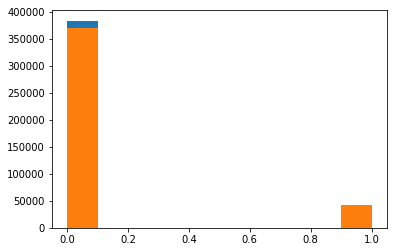

In [7]:
kk = model.predict(x_val,batch_size=batch_size,verbose=2)
print(kk)

print(kk.shape,y_val.shape)
plt.hist(np.round(kk))
plt.hist(y_val)
print(x_val.head())


In [8]:
print("Saved model to disk")
json_string = model.to_json()
with open("saved_models/model3.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('saved_models/weights3.h5')

Saved model to disk


In [9]:
print("predicting")
df_sub = pd.DataFrame()
df_sub_01 = pd.DataFrame()
ttest = pd.read_csv('test.csv')
print("finish read test data")

ttest, idd = clear_data(ttest,'test')
df_sub['click_id'] = idd.astype('int32')
df_sub_01['click_id'] = idd.astype('int32')

df_sub['is_attributed'] = model.predict(ttest,batch_size=batch_size,verbose=2)
df_sub_01['is_attributed'] = np.round(df_sub['is_attributed'])



predicting


check result
           click_id  is_attributed
count  1.879047e+07   1.879047e+07
mean   9.395234e+06   3.501248e-02
std    5.424341e+06   9.221052e-02
min    0.000000e+00   1.002655e-02
25%    4.697617e+06   1.517505e-02
50%    9.395234e+06   1.780828e-02
75%    1.409285e+07   2.078917e-02
max    1.879047e+07   8.321629e-01


(array([  1.82218530e+07,   1.44334000e+05,   4.64480000e+04,
          3.04970000e+04,   6.25600000e+03,   3.48610000e+04,
          3.76070000e+04,   7.25120000e+04,   3.96240000e+04,
          1.56477000e+05]),
 array([ 0.01002655,  0.09224019,  0.17445382,  0.25666746,  0.3388811 ,
         0.42109473,  0.50330837,  0.58552201,  0.66773564,  0.74994928,
         0.83216292]),
 <a list of 10 Patch objects>)

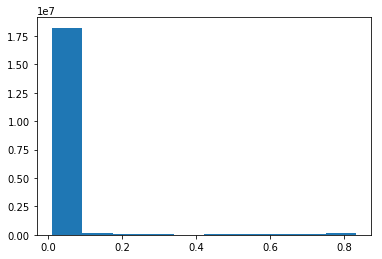

In [10]:
print("check result")
print(df_sub.describe())
plt.hist(df_sub['is_attributed'])

In [11]:
print("save the result")
df_sub.to_csv('sub_result/result_code3_sample10.csv',index=False)
df_sub_01.to_csv('sub_result/result_code3_sample10_01.csv',index=False)




save the result


(array([ 18482293.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,    308176.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

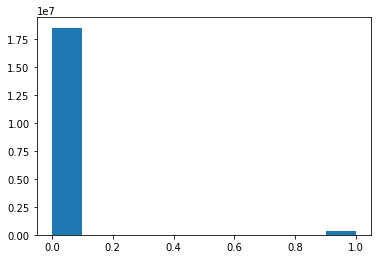

In [12]:
plt.hist(np.round(df_sub['is_attributed']))